In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from collections.abc import Hashable
from plotnine import *

RED = '#DB5F57'
BLUE = '#58D3DB'

In [8]:
df = pd.read_csv('Census_New.csv')
df.head()

,Age,Workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


# Preprocessing

In [9]:
features: list[str] = ['Age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
contin = ['Age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

dummy_feats: list[str] = ['Workclass', 'education', 'marital-status', 'relationship', 'occupation', 'race', 'sex', 'native-country']

output = 'Income'
weights = df['fnlwgt']


In [10]:
dummies = pd.get_dummies(df[dummy_feats])

features = dummies.columns.to_list()
features = contin + features

census = pd.concat([df, dummies], axis=1)
census = census.drop(columns=list[Hashable](dummy_feats))  

In [11]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(census[features], census[output], weights, random_state=42)

In [12]:
def plot_confusion_matrix(X: pd.DataFrame, y: pd.DataFrame, model: LogisticRegression, train = True):
  cm = confusion_matrix(y, model.predict(X)).flatten()
  matrix = pd.DataFrame({'True': ['0', '0', '1', '1'], 'Predicted': ['0', '1', '0', '1'], 'Y': cm})
  set = 'Train' if train else 'Test'
    
  return (ggplot(matrix, aes(x = 'True', y = 'Predicted'))
  + geom_tile(aes(fill = 'Y'), color = 'black', size = 0.5)
  + geom_text(aes(label = 'Y', color = 'Y'))
  + theme_minimal()
  + theme(legend_position='none',
          text = element_text(size = 12))
  + coord_fixed()
  + scale_color_gradient2(low = 'yellow',
  high = 'purple',
  midpoint = 1)
  + labs(title = f'{set} Set after Reduction Confusion Matrix')
  )

# Question 1
### How effective is using LASSO on our dataset for both feature reduction and improving our model’s generalizability on predicting whether someone has made less than or greater than 50k in income a year?

**Original Question:** Is there going to be any purpose in using dimensionality reduction on such a small dataset? Given the requirement however, is there any purpose in removing the columns that I have been considering removing in the first 3 questions before running PCA? Or should I let PCA simplify to the minimal number of inputs for me?

**Reasons for Change:** The primary reason that I changed my question was because I wasn't aware that PCA struggled with making accurate PCs for categorical variables. LASSO however, does not struggle with categorical variables, and in addition, is able to improve the generalizability of a model, so switching to LASSO reduction was the right move. Additionally, I wasn't originally aware that our dataset was as large as it was, so reduction was definitely a necessary component for our model.

In [13]:
z = make_column_transformer((StandardScaler(), contin), remainder = 'passthrough')
lasso = LogisticRegression(penalty = 'l1', solver='liblinear', max_iter=10000)

pipe = make_pipeline(z, lasso)

params = {"logisticregression__C": np.array([1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100])}

grid = GridSearchCV(pipe, params, scoring = 'accuracy', cv = 5, refit = True, n_jobs = -1)
grid.fit(X_train, y_train, logisticregression__sample_weight = weights_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'education-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e+00,
       5.e+00, 1.e+01, 1.e+02])},
             scoring='accuracy')

In [15]:
print("PENALTY:", grid.best_estimator_.get_params()["logisticregression__C"])
print("TRAIN:", accuracy_score(y_train, grid.predict(X_train)))
print("TEST :", accuracy_score(y_test, grid.predict(X_test)))

PENALTY: 1e-06
TRAIN: 0.8497133497133497
TEST : 0.856651517012652


In [16]:
features_reduced: list[str] = list(X_train.columns[(grid.best_estimator_['logisticregression'].coef_ != 0).ravel().tolist()])
num_features_red = len(features_reduced)
num_features = len(features)

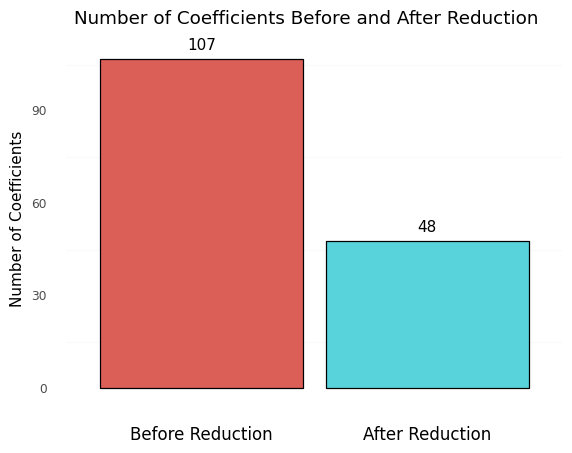

In [41]:
coefs = pd.DataFrame({'Reduced': ['Before Reduction', 'After Reduction'], 'Number of Coefficients': [num_features, num_features_red]})
coefs['Reduced'] = pd.Categorical(coefs['Reduced'], categories = coefs['Reduced'], ordered= True)
print((ggplot(coefs, aes(x = 'Reduced', y = 'Number of Coefficients', fill = 'factor(Reduced)'))
 + geom_bar(stat = 'identity', color = 'black')
 + theme_minimal()
 + labs(
   title = 'Number of Coefficients Before and After Reduction'
 )
 + geom_text(aes(label = 'Number of Coefficients'), 
             nudge_y = 2,
             va = 'bottom')
 + theme(legend_position = 'none',
         axis_title_x = element_blank(),
         axis_text_x = element_text(size = 12, color = 'black'),
         panel_grid_major = element_blank())
 + scale_fill_manual(values = [RED, BLUE])
 ))

In [38]:
z = StandardScaler()
X_train[contin] = z.fit_transform(X_train[contin])
X_test[contin] = z.transform(X_test[contin])

In [39]:
# All features
lr_non_reduced = LogisticRegression(max_iter=10000, penalty='none')
lr_non_reduced.fit(X_train, y_train, sample_weight = weights_train)

train_acc_no_reduc = accuracy_score(y_train, lr_non_reduced.predict(X_train), sample_weight = weights_train)
test_acc_no_reduc = accuracy_score(y_test, lr_non_reduced.predict(X_test), sample_weight = weights_test)


# Reduced features
lr_reduced = LogisticRegression(max_iter=10000, penalty='none')
lr_reduced.fit(X_train[features_reduced], y_train, sample_weight = weights_train)

train_acc_reduc = accuracy_score(y_train, lr_reduced.predict(X_train[features_reduced]), sample_weight = weights_train)
test_acc_reduc = accuracy_score(y_test, lr_reduced.predict(X_test[features_reduced]), sample_weight = weights_test)

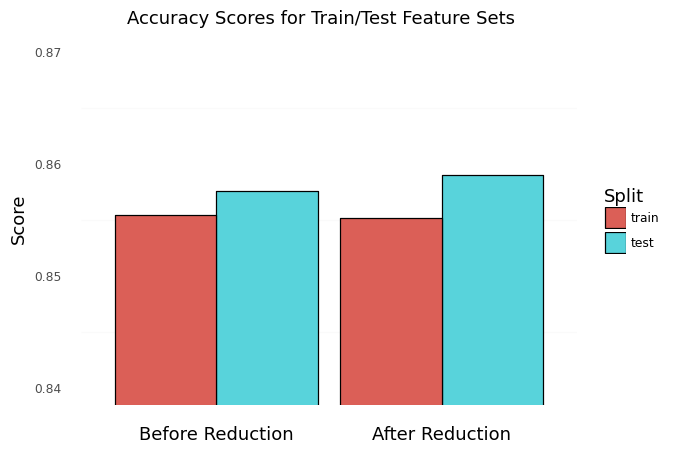

In [46]:
accuracies_reduc = {'Reduced': ['Before Reduction', 'Before Reduction', 'After Reduction', 'After Reduction'], 
                    'Split': ['train', 'test', 'train', 'test'], 
                    'Score': [train_acc_no_reduc, test_acc_no_reduc, train_acc_reduc, test_acc_reduc]}
accuracies_reduc = pd.DataFrame(accuracies_reduc)
accuracies_reduc['Reduced'] = pd.Categorical(accuracies_reduc['Reduced'], categories = accuracies_reduc['Reduced'].drop_duplicates(), ordered = True)
accuracies_reduc['Split'] = pd.Categorical(accuracies_reduc['Split'], categories = accuracies_reduc['Split'].drop_duplicates(), ordered = True)

print((ggplot(pd.DataFrame(accuracies_reduc), aes(x = 'Reduced', y = 'Score', fill = 'Split'))
 + geom_bar(position = 'dodge',stat = 'identity', color = 'black')
 + coord_cartesian(ylim=(0.84, 0.87))
 + theme_minimal()
 + labs(title = 'Accuracy Scores for Train/Test Feature Sets')
 + theme(axis_title = element_text(size = 13),
         title = element_text(size = 13),
         axis_title_x = element_blank(),
         axis_text_x = element_text(size = 13, color = 'black'),
         panel_grid_major = element_blank()
 )
 + scale_fill_manual(values = [RED, BLUE])
))

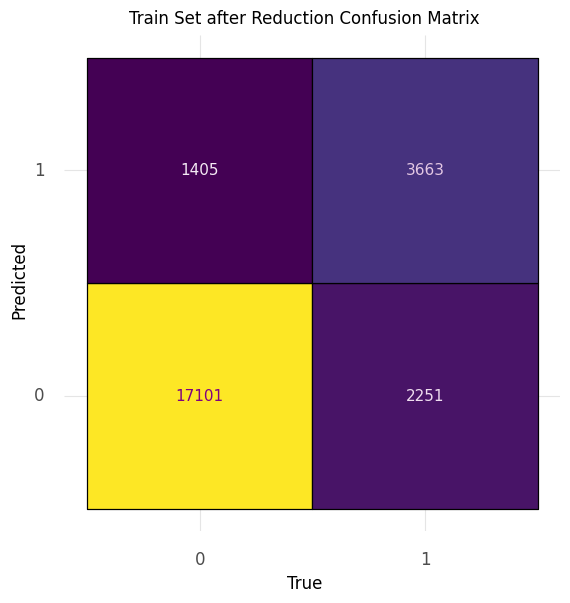

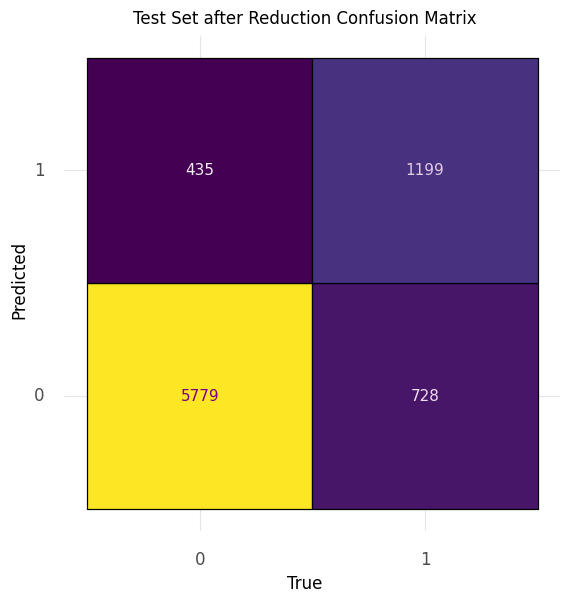

In [36]:
cm_train = plot_confusion_matrix(X_train[features_reduced], y_train, lr_reduced)
cm_test = plot_confusion_matrix(X_test[features_reduced], y_test, lr_reduced, False)

print(cm_train, cm_test)

## **Answer**

Overall, LASSO played a huge role on improving our model. Originally having a feature set of **107** (including dummies), LASSO helped us preserve an almost identical accuracy (pre-reduction train/test: 0.855, 0.858 - post-reduction train/test: 0.855, 0.859) with a reduced feature set of only **48**. This saved a large amount of time on training during this project, and would save a considerably larger amount of time if further analysis were to be conducted on this dataset with more data. Additionally, LASSO very slightly improved our test accuracy - consequently improving our model's generalizability. Our reduced model may have room to improve on generalizability even more, through potential further analysis using a different regularization type - RIDGE or Elastic-Net - on our reduced model. To arrive to these conclusions, I first grid searched using cross validation for an optimal $ \alpha $ (or in our case with sklearn Logistic Regression $ C = \frac{1}{\alpha}$) which would maintain a similar accuracy - but while pushing for a larger $ \alpha $ to most effectively reduce the feature count. After finding the most optimal $ \alpha $ using LASSO, we examined the coefficients that LASSO had dragged to 0 in the grid search - ultimately removing those from the 
feature set. Finally, using our reduced feature set, we trained a simple Logistic Regression model and validated that it was going to perform the same as the optimal grid search model through examining the train/test accuracies and confusion matrices. Receiving almost identical accuracies, and confirming that our model was predicting a majority of the data points correctly through seeing our confusion matrices, we can confirm the effectiveness of LASSO reduction on our model.

# Question 2
### Should we include both, one of, or neither relationship and marital-status in our model when they both represent an almost identical piece of information? Can we **further** reduce our feature count while maintaining a similar accuracy for predicting whether someone has made less than or more than 50k in income in a year?


In [47]:
# This creates the 3 missing feature sets - one for all but marital features, one for all but relationship features, and one that has neither marital nor relationship features

features_no_relationship = list(set(features) - set(['relationship']))
features_no_marital = list(set(features) - set(['marital-status']))

dummy_feats_no_relationship = list(set(dummy_feats) - set(['relationship']))
dummy_feats_no_marital = list(set(dummy_feats) - set(['marital-status']))

dummies_no_relationship = pd.get_dummies(df[dummy_feats_no_relationship])
dummies_no_marital = pd.get_dummies(df[dummy_feats_no_marital])

features_no_relationship = dummies_no_relationship.columns.to_list()
features_no_relationship = list(set(contin + features_no_relationship) & set(features_reduced))

features_no_marital = dummies_no_marital.columns.to_list()
features_no_marital = list(set(contin + features_no_marital) & set(features_reduced))

features_neither = list(set(features_no_marital) & set(features_no_relationship))

In [48]:
lr_all = LogisticRegression(penalty = 'none', max_iter = 10000)
lr_all.fit(X_train[features_reduced], y_train, sample_weight = weights_train)

lr_no_marital = LogisticRegression(penalty = 'none', max_iter = 10000)
lr_no_marital.fit(X_train[features_no_marital], y_train, sample_weight = weights_train)

lr_no_relationship = LogisticRegression(penalty = 'none', max_iter = 10000)
lr_no_relationship.fit(X_train[features_no_relationship], y_train, sample_weight = weights_train)

lr_neither = LogisticRegression(penalty = 'none', max_iter = 10000)
lr_neither.fit(X_train[features_neither], y_train, sample_weight = weights_train)

LogisticRegression(max_iter=10000, penalty='none')

In [49]:
train_acc_all = accuracy_score(y_train, lr_all.predict(X_train[features_reduced]), sample_weight = weights_train)
test_acc_all = accuracy_score(y_test, lr_all.predict(X_test[features_reduced]), sample_weight = weights_test)

train_acc_no_marital = accuracy_score(y_train, lr_no_marital.predict(X_train[features_no_marital]), sample_weight = weights_train)
test_acc_no_marital = accuracy_score(y_test, lr_no_marital.predict(X_test[features_no_marital]), sample_weight = weights_test)

train_acc_no_relationship = accuracy_score(y_train, lr_no_relationship.predict(X_train[features_no_relationship]), sample_weight = weights_train)
test_acc_no_relationship = accuracy_score(y_test, lr_no_relationship.predict(X_test[features_no_relationship]), sample_weight = weights_test)

train_acc_neither = accuracy_score(y_train, lr_neither.predict(X_train[features_neither]), sample_weight = weights_train)
test_acc_neither = accuracy_score(y_test, lr_neither.predict(X_test[features_neither]), sample_weight = weights_test)

print("All features train/test acc: ", train_acc_all, test_acc_all)
print("No marital train/test acc: ", train_acc_no_marital, test_acc_no_marital)
print("No relationship train/test acc: ", train_acc_no_relationship, test_acc_no_relationship)
print("Neither train/test acc: ", train_acc_neither, test_acc_neither)

All features train/test acc:  0.8552595129149592 0.8590251677263053
No marital train/test acc:  0.8546311289606865 0.8592098490626054
No relationship train/test acc:  0.8542449106891685 0.8599985642932809
Neither train/test acc:  0.8340306342299212 0.8338993792617316


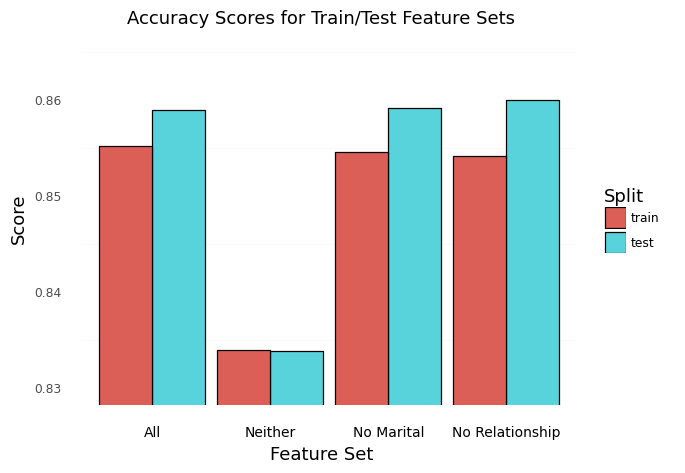

<ggplot: (313935233)>

In [54]:
accuracies = {'Feature Set': ['All', 'All', 'No Marital', 'No Marital', 'No Relationship', 'No Relationship', 'Neither',  'Neither'], 
              'Split': ['train', 'test', 'train', 'test', 'train', 'test', 'train', 'test'], 
              'Score': [train_acc_all, test_acc_all, train_acc_no_marital, test_acc_no_marital, train_acc_no_relationship, test_acc_no_relationship, train_acc_neither, test_acc_neither]}
accuracies = pd.DataFrame(accuracies)
accuracies['Split'] = pd.Categorical(accuracies['Split'], categories = accuracies['Split'].drop_duplicates(), ordered = True)


(ggplot(pd.DataFrame(accuracies), aes(x = 'Feature Set', y = 'Score', fill = 'Split'))
 + geom_bar(position = 'dodge',stat = 'identity', color = 'black')
 + coord_cartesian(ylim=(0.83, 0.865))
 + theme_minimal()
 + labs(title = 'Accuracy Scores for Train/Test Feature Sets')
 + theme(axis_title = element_text(size = 13),
         title = element_text(size = 13),
        axis_text_x = element_text(size = 10, color = 'black'),
        panel_grid_major = element_blank()
 )
 + scale_fill_manual([RED, BLUE])
)


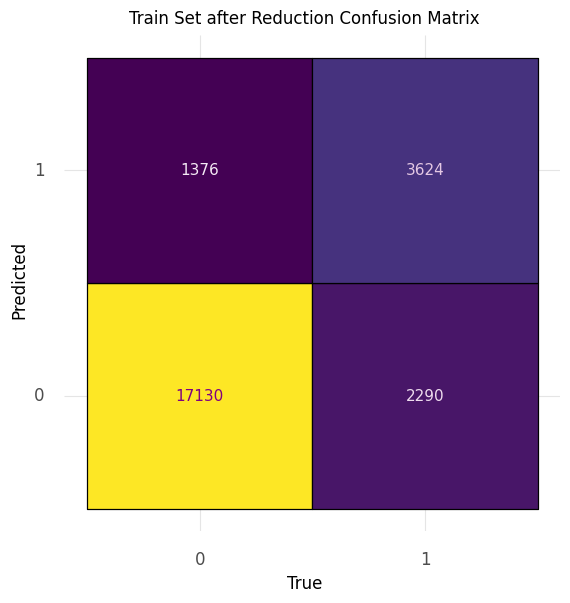

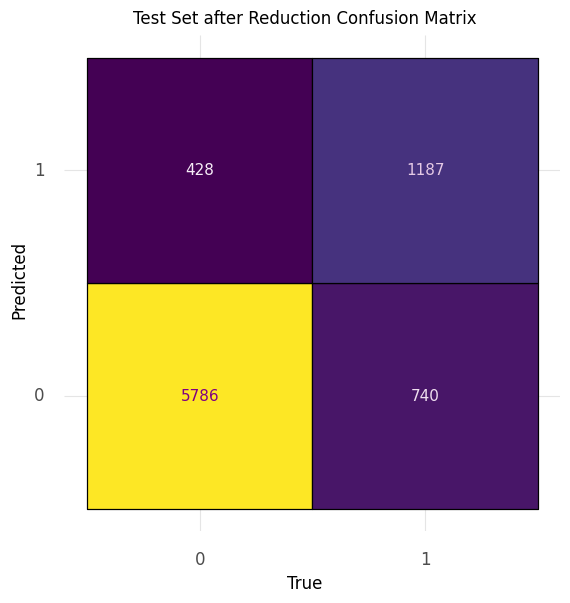

In [51]:
cm_train = plot_confusion_matrix(X_train[features_no_relationship], y_train, lr_no_relationship)
cm_test = plot_confusion_matrix(X_test[features_no_relationship], y_test, lr_no_relationship, train = False)

print(cm_train, cm_test)

## **Answer**
Using our reduced feature set of **48**, we were able to conclude that we only needed to include either marital-status or relationship in our model, rather than keeping both. Taking out one or the other produced almost identical accuracies, so we decided that - to reduce our model as much as possible - that we would take out relationship, reducing our feature set from **48** to **43** (taking our marital-status would result in **45**). Interestingly, taking out both marital-status and relationship resulted in a lower accuracy than keeping both or just one of the two. This gives reason to believe that these two features **are related**, but still pose as an important enough feature in our model to improve its accuracy. To arrive at these conclusions, we set up the 3 other feature sets (all features, no marital-status, no relationship) from our reduced set, and trained 4 different independent models on each feature set (including our original reduced feature set). We then analyzed how well each performed through accuracies and confusion matrices, and saw that including one or both of the features produced almost identical train/test accuracies, while including neither underperformed with a lower accuracy. Choosing the no relationship feature set to reduce our feature count as much as possible, we finally looked at the train/test confusion matrices, and saw almost identical matrices to those from our original reduced feature set model - allowing us to conclude that removing marital-status from our feature set was the right choice.